In [1]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Adding {project_root} to sys.path")

Adding d:\JoshFile\Github\spoofing-recognition\training to sys.path


In [3]:
import config

## randomizer

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


## Utils Functions


In [ ]:
import copy 

def train_model(model, device, train_loader, val_loader, criterion, optimizer, epochs, early_stopping_limit=3):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_precision': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_val_precision = 0.0
    early_stopping_counter = 0
    

    for epoch in range(epochs):
        # --- TRAINING PHASE ---
        model.train()
        train_loss = 0.0
        
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
     
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        true_positives = 0
        false_positives = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                true_positives  += ((predicted == 1) & (labels == 1)).sum().item()
                false_positives += ((predicted == 1) & (labels == 0)).sum().item()




        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        if (true_positives + false_positives) > 0:
            val_precision = 100 * true_positives / (true_positives + false_positives)
        else:
            val_precision = 0.0
        
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Precision: {val_precision:.2f}%")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_precision'].append(val_precision)


   
        if best_val_loss > avg_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0 
            print("  -> New best model saved!")
        else:
            early_stopping_counter += 1 
            print(f"  -> No improvement. Counter: {early_stopping_counter}/{early_stopping_limit}")

  
        if early_stopping_counter >= early_stopping_limit:
            print("Early stopping triggered.")
            break


    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
def display_train_result(history):
    fig_loss, ax1 = plt.subplots()
    ax1.plt.plot(history['train_loss'], label='Train Loss')
    ax1.plt.plot(history['val_loss'], label='Val Loss')
    ax1.plt.xlabel('Epochs')
    ax1.plt.ylabel('Value')
    ax1.plt.legend()
    ax1.plt.show()

    fig_precision, ax2 = plt.subplots() 
    ax2.plt.plot(history['val_precision'], label='Val Precision')
    ax2.plt.xlabel('Epochs')
    ax2.plt.ylabel('Value')
    ax2.plt.legend()
    ax2.plt.show()

    return fig_loss, fig_precision


In [27]:
def checkImage(small_train_ds):
    sample_img, sample_label = small_train_ds
    display_img = sample_img.permute(1, 2, 0)
    display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min())
    plt.imshow(display_img)
    plt.title(f"Label: {'Live' if sample_label == 0 else 'Spoof'}")
    plt.axis('off')
    plt.show()

## Params

In [28]:
BBOX_ORGINAL_SIZE = 224
TARGET_SIZE = 500

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Add Augmentation for Training
train_transform = transforms.Compose([
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Keep Validation/Test pure (Resize only)
val_transform = transforms.Compose([
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Model


In [29]:
from torchvision import models
import torch.nn as nn

# Load EfficientNet (Pre-trained on 1 million images)
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Adjust the final layer for 2 classes (Live/Spoof)
# EfficientNet uses .classifier instead of .fc
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 2)



## Dataloader

In [30]:
import os
import glob
import json
from torch.utils.data import Dataset

from PIL import Image

class CelebASpoofDataset(Dataset):

    
    def __init__(self, root_dir, json_label_path, transform=None):
        """
        Args:
            root_dir: Path to the 'data' folder
            json_label_path: Path to the train_label.json or test_label.json
            transform: PyTorch transforms
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Load the JSON labels
        with open(json_label_path, 'r', encoding='utf-8') as f:
            self.label_dict = json.load(f)
            
        # The JSON keys are the relative paths to the images
        self.image_keys = list(self.label_dict.keys())

    def __len__(self):
        return len(self.image_keys)

    def __getitem__(self, idx):
        # 1. Get image path and labels from JSON
        rel_path = self.image_keys[idx]
        full_path = os.path.join(self.root_dir, rel_path)
        
        # Labels from JSON: [43] is the live/spoof index
        # 1: spoof, 0: live (usually, verify with your data_description)
        all_labels = self.label_dict[rel_path]
        label = torch.tensor(all_labels[43]) 

        # 2. Open Image
        image = Image.open(full_path).convert("RGB")
        real_w, real_h = image.size

        # 3. Handle Bounding Box
        # Example txt path: data/train/1/live/000184_BB.txt
        base_path, _ = os.path.splitext(full_path)
        txt_path = base_path + "_BB.txt"
        
        if os.path.exists(txt_path):
            with open(txt_path, 'r', encoding='utf-8') as f:
                bbox = list(map(float, f.read().strip().split()))
                if len(bbox) >= 4:
                    # Scaling logic from README
                    x1 = int(bbox[0] * (real_w / BBOX_ORGINAL_SIZE))
                    y1 = int(bbox[1] * (real_h / BBOX_ORGINAL_SIZE))
                    w1 = int(bbox[2] * (real_w / BBOX_ORGINAL_SIZE))
                    h1 = int(bbox[3] * (real_h / BBOX_ORGINAL_SIZE))
                    
                    # Crop (left, top, right, bottom)
                    image = image.crop((x1, y1, x1 + w1, y1 + h1))

        # 4. Apply Final Resizing and Normalization
        if self.transform:
            image = self.transform(image)

        return image, label
    


## preparation


In [31]:


BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    transform=train_transform
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    transform=val_transform
)
device

device(type='cuda')

In [32]:
len(train_ds)

494405

In [33]:
# use only 1000 images for training next 500 for validation

small_ds = torch.utils.data.Subset(train_ds, list(range(1500)))
small_train_ds = torch.utils.data.Subset(small_ds, list(range(0, 1000)))
small_val_ds = torch.utils.data.Subset(small_ds, list(range(1000, 1500)))
len(small_train_ds)

1000

In [34]:
small_test_ds = torch.utils.data.Subset(test_ds, list(range(200)))

In [35]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, batch_size=BATCH_SIZE, shuffle=True)
small_val_loader = DataLoader(small_val_ds, batch_size=BATCH_SIZE, shuffle=False)
small_test_loader = DataLoader(small_test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 500, 500]), tensor(0))

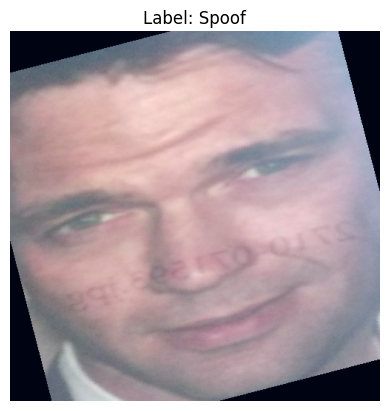

In [37]:
# 1 = spoof  0 = live 
checkImage(small_train_ds[10])

## Train

In [38]:
model, history = train_model(model=model, device=device, train_loader=small_train_loader, val_loader=small_val_loader, criterion=criterion, optimizer=optimizer, epochs=10)

Epoch [1/10] Train Loss: 0.2431 | Val Loss: 0.0850 | Val Precision: 96.52%
  -> New best model saved!
Epoch [2/10] Train Loss: 0.1636 | Val Loss: 0.0390 | Val Precision: 98.54%
  -> New best model saved!
Epoch [3/10] Train Loss: 0.1345 | Val Loss: 0.0382 | Val Precision: 99.70%
  -> New best model saved!
Epoch [4/10] Train Loss: 0.1181 | Val Loss: 0.0638 | Val Precision: 99.40%
  -> No improvement. Counter: 1/3
Epoch [5/10] Train Loss: 0.1042 | Val Loss: 0.0376 | Val Precision: 100.00%
  -> New best model saved!
Epoch [6/10] Train Loss: 0.0468 | Val Loss: 0.0435 | Val Precision: 97.40%
  -> No improvement. Counter: 1/3
Epoch [7/10] Train Loss: 0.0670 | Val Loss: 0.0498 | Val Precision: 99.70%
  -> No improvement. Counter: 2/3
Epoch [8/10] Train Loss: 0.1038 | Val Loss: 0.0404 | Val Precision: 98.83%
  -> No improvement. Counter: 3/3
Early stopping triggered.


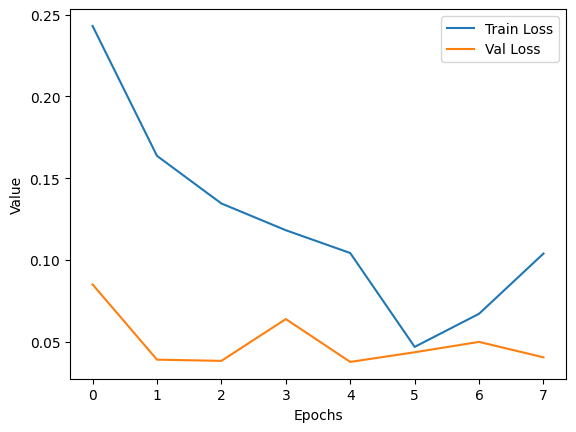

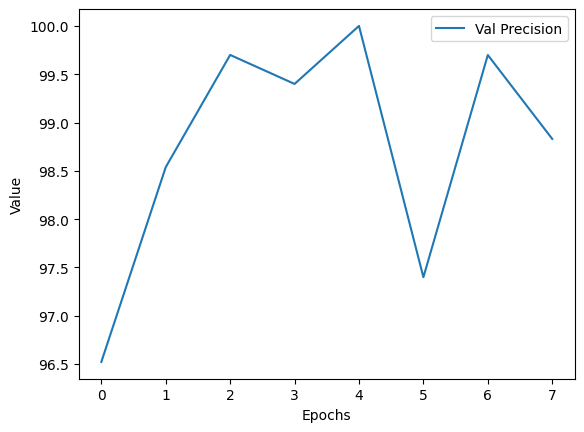

In [39]:

display_train_result(history)

In [40]:
history

{'train_loss': [0.24307488891482354,
  0.16359842701256275,
  0.13447358486056327,
  0.11812244294211269,
  0.10417718314379454,
  0.04677527687698603,
  0.067019697453361,
  0.10384938514977693],
 'val_loss': [0.08496957859769463,
  0.03896420214325189,
  0.03821702602063306,
  0.06379430528823286,
  0.03757406347244978,
  0.0434843810727325,
  0.04982969070225954,
  0.040378034263849255],
 'val_precision': [96.52173913043478,
  98.53801169590643,
  99.69969969969969,
  99.3993993993994,
  100.0,
  97.39884393063583,
  99.6987951807229,
  98.83040935672514]}

## test

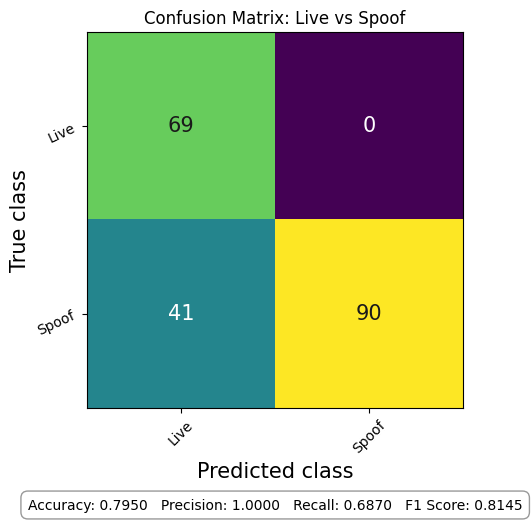

Accuracy: 0.7950
Precision: 1.0000
Recall:    0.6870
F1 Score:  0.8145


In [41]:
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
def evaluate(model, dataloader, device):
    confmat = MulticlassConfusionMatrix(num_classes=2).to(device)
    accuracy = Accuracy(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    f1 = F1Score(task="binary").to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Update the metrics with this batch
            confmat.update(preds, labels)
            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

    # Compute the final results
    final_matrix = confmat.compute()
    acc_val = accuracy.compute()
    prec_val = precision.compute()
    rec_val = recall.compute()
    f1_val = f1.compute()

    # Plot the matrix
    fig, ax = confmat.plot(labels=["Live", "Spoof"])
    ax.set_title("Confusion Matrix: Live vs Spoof")
    
    # Add metrics as text below the matrix
    metrics_text = (f"Accuracy: {acc_val:.4f}   "
                    f"Precision: {prec_val:.4f}   "
                    f"Recall: {rec_val:.4f}   "
                    f"F1 Score: {f1_val:.4f}")
    
    # Position the text at the bottom center of the figure
    fig.text(0.5, -0.05, metrics_text, ha='center', fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))
    
    plt.show()

    print(f"Accuracy: {acc_val:.4f}")
    print(f"Precision: {prec_val:.4f}")
    print(f"Recall:    {rec_val:.4f}")
    print(f"F1 Score:  {f1_val:.4f}")

    return final_matrix, acc_val, prec_val, rec_val, f1_val

confusion_matrix, accuracy, precision, recall, f1 = evaluate(model=model, dataloader=small_test_loader, device=device)

In [ ]:
from pathlib import Path
def create_save_new_path(path_name, num):
    new_dir = f"{path_name}_{num}"
    if Path(new_dir).exist:
        num += 1
        return create_save_new_path(path_name, num)
    else:
        os.mkdir(new_dir)
        return new_dir



def save_results(model, confusion_matrix_fig, train_loss_fig, precision_fig):
    
    save_path = Path("train_results/")
    path_name = "train_"
    num = 0
    
    save_path.mkdir(parents=True, exist_ok=True)
    
    # create new dir if already exist
    new_path = create_save_new_path(path_name)



    torch.save(model.state_dict(), new_path)
save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig, precision_fig)

TypeError: save_results() got an unexpected keyword argument 'confusion_matrix'

NameError: name 'final_matrix' is not defined